Show atlas and display marker data on top of SNR.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *
from registration_utilities import *
from vis3d_utilities import *
from metadata import *
from data_manager import *

import time

import matplotlib.pyplot as plt
%matplotlib inline

ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.


Setting environment for Local Macbook Pro


File does not exist: /home/yuncong/CSHL_data_processed/DEMO999/DEMO999_anchor.txt
File does not exist: /home/yuncong/CSHL_data_processed/DEMO999/DEMO999_sorted_filenames.txt
File does not exist: /home/yuncong/CSHL_data_processed/DEMO999/DEMO999_sorted_filenames.txt
File does not exist: /home/yuncong/CSHL_data_processed/DEMO999/DEMO999_anchor.txt
File does not exist: /home/yuncong/CSHL_data_processed/DEMO999/DEMO999_anchor.txt
File does not exist: /home/yuncong/CSHL_data_processed/DEMO999/DEMO999_anchor.txt


In [2]:
atlas_name = 'atlasV7'

In [3]:
atlas_spec = dict(name=atlas_name, resolution='10.0um', vol_type='score')

In [10]:
SNR_L_vol_10um, SNR_L_origin_10um_wrt_canonicalAtlasSpace =\
DataManager.load_original_volume_v2(stack_spec=atlas_spec, structure='SNR_L', bbox_wrt='canonicalAtlasSpace')

In [5]:
# SNR_R_vol_10um, SNR_R_ori_10um_wrt_canonicalAtlasSpace =\
# DataManager.load_original_volume_v2(stack_spec=atlas_spec, structure='SNR_R', bbox_wrt='canonicalAtlasSpace')

In [6]:
# SNR_L_nominal_location_1um_wrt_canonicalAtlasSpace = load_data(DataManager.get_structure_mean_positions_filepath(atlas_name=atlas_name, resolution='1um'))['SNR_L']
# SNR_L_nominal_location_10um_wrt_canonicalAtlasSpace = SNR_L_nominal_location_1um_wrt_canonicalAtlasSpace / 10.

In [7]:
# SNR_L_vol_10um, SNR_L_origin_10um_wrt_canonicalAtlasSpace = \
# mirror_volume_v2(SNR_R_vol_10um, SNR_L_nominal_location_10um_wrt_canonicalAtlasSpace)

In [8]:
# SNR_L_vol_down32, SNR_L_origin_down32_wrt_canonicalAtlasSpace = \
# mirror_volume_v2(SNR_R_vol_down32, SNR_L_nominal_location_down32_wrt_canonicalAtlasSpace - get_centroid_3d(SNR_R_vol_down32) * (1,1,-1))

In [12]:
# SNR_L_mesh_level01_vertices_10um, SNR_L_mesh_level01_faces = \
# volume_to_polydata(volume=(SNR_L_vol_10um >= .1, SNR_L_origin_10um_wrt_canonicalAtlasSpace), 
#                      num_simplify_iter=3, smooth=True, 
#                      return_vertex_face_list=True)

SNR_L_mesh_level01_vertices_10um, SNR_L_mesh_level01_faces = \
volume_to_polydata(volume=(SNR_L_vol_10um, SNR_L_origin_10um_wrt_canonicalAtlasSpace), 
                   level=0.000001,
                     num_simplify_iter=4, smooth=True, 
                     return_vertex_face_list=True)

marching cube: 0.36 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 72973: 0.77 seconds
simplify 1 @ 14596: 0.76 seconds
simplify 2 @ 2920: 0.15 seconds
simplify 3 @ 585: 0.03 seconds


In [10]:
SNR_L_mesh_level01_um = mesh_to_polydata(vertices=SNR_L_mesh_level01_vertices_10um * 10., 
                                         faces=SNR_L_mesh_level01_faces)

In [32]:
v, o, _ = polydata_to_volume(SNR_L_mesh_level01_um)
print np.count_nonzero(v > 0) / 1e9, 'mm^3'

In [11]:
atlas_meshes_10um = DataManager.load_meshes_v2(atlas_spec, sided=True, return_polydata_only=False, 
                                               include_surround=False, levels=0.5)

In [12]:
atlas_meshes_um = {s: mesh_to_polydata(vertices=v*10., faces=f) for s, (v, f) in atlas_meshes_10um.iteritems()}

In [13]:
atlas_meshes_um['SNR_L'] = SNR_L_mesh_level01_um

In [14]:
atlas_structure_actors_um = {s: actor_mesh(m,  
                       color=np.array(name_unsided_to_color[convert_to_unsided_label(s)])/255.,
#                                      opacity=(0.2 if s == 'SNR_L' else 0.03),
                                           opacity=(0.95 if s == 'SNR_L' else 0.03),
                                    )
            for s, m in atlas_meshes_um.iteritems()}

In [15]:
# shell_polydata_10um_wrt_MD589wholebrain = DataManager.load_mesh_v2(brain_spec=dict(name='MD589', vol_type='annotationAsScore', resolution='10.0um'), structure='shell')
# shell_polydata_um_wrt_MD589wholebrain = rescale_polydata(shell_polydata_10um_wrt_MD589wholebrain, 
#                                 convert_resolution_string_to_um(resolution='10.0um'))

# transform_matrix_from_MD589_to_canonicalAtlasSpace_um = \
# np.array([[  9.99360483e-01,   1.60938754e-03,  -3.57253260e-02,  -1.17026747e+04],
#  [  1.60938754e-03,   9.95949871e-01,   8.99051267e-02 , -6.06489183e+03],
#  [  3.57253260e-02,  -8.99051267e-02,   9.95310353e-01 , -4.54015815e+03],
#  [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00 ,  1.00000000e+00]])

# shell_polydata_um_wrt_canonicalAtlasSpace = transform_polydata(transform=transform_matrix_from_MD589_to_canonicalAtlasSpace_um,
#                   polydata=shell_polydata_um_wrt_MD589wholebrain)

# # shell_polydata_down32_wrt_canonicalAtlasSpace = rescale_polydata(shell_polydata_um_wrt_canonicalAtlasSpace, 1./14.)
# shell_polydata_10um_wrt_canonicalAtlasSpace = rescale_polydata(shell_polydata_um_wrt_canonicalAtlasSpace, 1./14.)

# shell_actor_um_wrt_canonicalAtlasSpace = actor_mesh(shell_polydata_um_wrt_canonicalAtlasSpace, (1,1,1), opacity=.15, 
#                               wireframe=False)

# shell_actor_10um_wrt_canonicalAtlasSpace = actor_mesh(shell_polydata_10um_wrt_canonicalAtlasSpace, (1,1,1), opacity=.15, 
#                               wireframe=False)

In [16]:
shell_polydata_10um_wrt_canonicalAtlasSpace = DataManager.load_mesh_v2(brain_spec=dict(name='atlasV7', vol_type='score', resolution='10.0um'), 
                                                                   structure='shell')

shell_polydata_um_wrt_canonicalAtlasSpace = rescale_polydata(shell_polydata_10um_wrt_canonicalAtlasSpace, 10.)

shell_actor_um_wrt_canonicalAtlasSpace = actor_mesh(shell_polydata_um_wrt_canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)

shell_actor_10um_wrt_canonicalAtlasSpace = actor_mesh(shell_polydata_10um_wrt_canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)

In [21]:
launch_vtk(atlas_structure_actors_um.values() \
           + [shell_actor_um_wrt_canonicalAtlasSpace] \
           + [actor_sphere(position=(0,0,0), radius=5, color=(1,1,1), opacity=1.)])

In [13]:
experiments = {
#             'LM30': {'injection_structure': 'SNR_L', 'marker_color': (0,.5,0)},
#             'LM40': {'injection_structure': 'SNR_L', 'marker_color': (1,0,1)},
#             'LM30new': {'injection_structure': 'SNR_L', 'marker_color': (0,1,0)},
#             'LM40new': {'injection_structure': 'SNR_L', 'marker_color': (1,0,0)},
#             'LM31': {'injection_structure': 'SNR_L', 'marker_color': (0,0,1)},
#             'LM38': {'injection_structure': 'SNR_L', 'marker_color': (1,1,0)},
#             'LM48': {'injection_structure': 'SNR_L', 'marker_color': (0,1,1)},
#                 'LM42_LM37': {'injection_structure': 'SNR_L', 'marker_color': (1,0,1)},
#             'LM46': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM22': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#                 'LM41': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM86': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM84': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#                 'LM32': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
#             'LM72': {'injection_structure': 'SNR_L', 'marker_color': np.array(random_colors(1)[0])/255.},
    
    'LM30new': {'injection_site': 'LSC', 'marker_color': (0,1,0)},
    'LM86': {'injection_site': 'LSC', 'marker_color': (0,1,0)},
    'LM27': {'injection_site': 'LSC', 'marker_color': (0,1,0)},
    
    'LM41': {'injection_site': 'CSC', 'marker_color': tuple(np.array([96, 201, 242])/255.)},
    'LM22': {'injection_site': 'CSC', 'marker_color': tuple(np.array([96, 201, 242])/255.)},
    'LM17': {'injection_site': 'CSC', 'marker_color': tuple(np.array([96, 201, 242])/255.)},
    
    'LM37': {'injection_site': 'MSC', 'marker_color': tuple(np.array([255, 255, 0])/255.)},
    'LM95': {'injection_site': 'MSC', 'marker_color': tuple(np.array([255, 255, 0])/255.)},  

    'LM38': {'injection_site': 'IC', 'marker_color': tuple(np.array((180, 239, 86))/255.)},
    'LM32': {'injection_site': 'IC', 'marker_color': tuple(np.array((180, 239, 86))/255.)},
    
    'LM40new': {'injection_site': 'DR', 'marker_color': tuple(np.array((255, 0, 0))/255.)},
    'LM54': {'injection_site': 'DR', 'marker_color': tuple(np.array((255, 0, 0))/255.)},
    'LM94_LM96_LM25': {'injection_site': 'DR', 'marker_color': tuple(np.array((255, 0, 0))/255.)},
    
    'LM46': {'injection_site': 'Pno', 'marker_color': tuple(np.array((0, 0, 255))/255.)},
    'LM84': {'injection_site': 'Pno', 'marker_color': tuple(np.array((0, 0, 255))/255.)},
    
    'LM31': {'injection_site': 'PcRT', 'marker_color': tuple(np.array((178, 0, 255))/255.)},
    'LM48': {'injection_site': 'PcRT', 'marker_color': tuple(np.array((178, 0, 255))/255.)},
    
#             'MD661': {'injection_structure': '5N_L', 'marker_color': (1,0,0)},
#              'MD662': {'injection_structure': '7N_L', 'marker_color': (0,1,0)},
#               'MD658': {'injection_structure': '5N_L', 'marker_color': (0,0,1)}
}

In [71]:
import pandas as pd

In [72]:
pd.DataFrame(experiments).T.to_csv('../demo/lauren_experiments.csv')

In [73]:
experiments = pd.read_csv('../demo/lauren_experiments.csv', index_col=0).T.to_dict()

In [77]:
marker_resolution = '10.0um'

In [82]:
from ast import literal_eval

In [81]:
markers_rel2atlas_actors = {}
aligned_markers_rel2atlas_um_all_brains = {}

for brain_name, experiment_info in experiments.iteritems():
    
    # Load Neurolucida format.
    
    markers = load_data(DataManager.get_lauren_markers_filepath(brain_name, structure='All', resolution=marker_resolution))
    
#     sample_n = min(len(markers), max(len(markers)/5, 10))
    sample_n = min(len(markers), 50)
    print brain_name, 'showing', sample_n, '/', len(markers)
    markers = markers[np.random.choice(range(len(markers)), size=sample_n, replace=False)]
    
    brain_f_spec = dict(name=brain_name, vol_type='annotationAsScore', structure='SNR_L', resolution='10.0um')
    brain_m_spec = dict(name=atlas_name, resolution='10.0um', vol_type='score', structure='SNR_L')
    alignment_spec = dict(stack_m=brain_m_spec, stack_f=brain_f_spec, warp_setting=7)
    
    tf_atlas_to_subj = DataManager.load_alignment_results_v3(alignment_spec, what='parameters', out_form=(4,4))
    
    markers_rel2subj = {marker_id: marker_xyz for marker_id, marker_xyz in enumerate(markers)}
    
    aligned_markers_rel2atlas = {marker_ind: transform_points(pts=p, transform=np.linalg.inv(tf_atlas_to_subj)) 
                                for marker_ind, p in markers_rel2subj.iteritems()}

    aligned_markers_rel2atlas_um = {marker_ind: p * convert_resolution_string_to_um(marker_resolution) 
                                    for marker_ind, p in aligned_markers_rel2atlas.iteritems()}

    aligned_markers_rel2atlas_um_all_brains[brain_name] = aligned_markers_rel2atlas_um

    markers_rel2atlas_actors[brain_name] = [actor_sphere(position=(x,y,z), radius=20, 
                                                        color=literal_eval(experiment_info['marker_color']),
                                                        opacity=.8 )
                               for marker_id, (x,y,z) in aligned_markers_rel2atlas_um.iteritems()]

LM94_LM96_LM25 showing 50 / 267
LM38 showing 10 / 10
LM30new showing 50 / 553
LM22 showing 50 / 210
LM27 showing 50 / 1138
LM37 showing 6 / 6
LM17 showing 50 / 166
LM32 showing 50 / 165
LM31 showing 50 / 73
LM48 showing 50 / 399
LM95 showing 19 / 19
LM41 showing 50 / 350
LM84 showing 50 / 63
LM40new showing 36 / 36
LM86 showing 50 / 902
LM54 showing 6 / 6
LM46 showing 50 / 253


In [20]:
launch_vtk([m for b, marker_actors in markers_rel2atlas_actors.iteritems() for m in marker_actors ] \
          + atlas_structure_actors_um.values() \
           + [shell_actor_um_wrt_canonicalAtlasSpace] \
#            + [actor_sphere(position=(0,0,0), radius=5, color=(1,1,1), opacity=1.)]
           , 
           init_angle='sagittal'
          )

In [168]:
save_json({brain: {mid: coords.tolist() for mid, coords in x.iteritems() } for brain, x in aligned_markers_rel2atlas_um_all_brains.iteritems()}, 
          '/home/yuncong/Dropbox/Lauren XML files/registration_results/marker_coordinates_aligned_to_atlas.json')

# Generate coronal planes at specific levels

In [ ]:
SNR_L_nominal_location_um_wrt_canonicalAtlasSpace = SNR_L_nominal_location_down32_wrt_canonicalAtlasSpace * convert_resolution_string_to_um('down32', stack='MD589')
SNR_L_vol_down32_level01 = SNR_L_vol_down32 >= 0.1
SNR_L_vol_down32_level01_centroid_wrt_SNR_L_origin = get_centroid_3d(SNR_L_vol_down32_level01)
print SNR_L_vol_down32_level01_centroid_wrt_SNR_L_origin
ydim, xdim, zdim = SNR_L_vol_down32_level01.shape

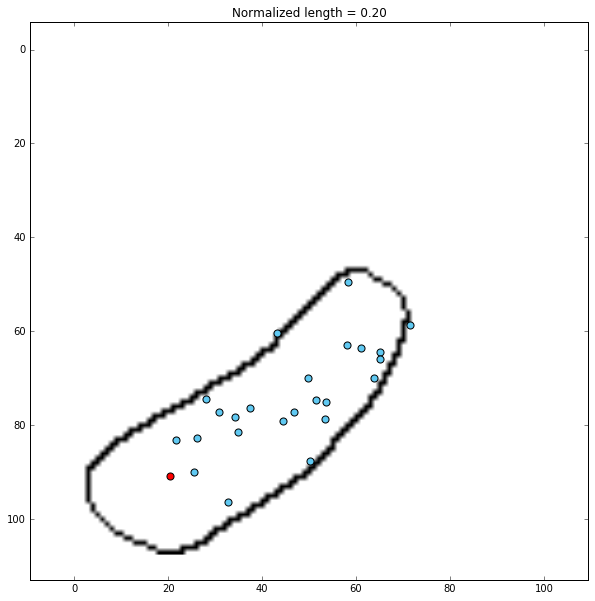

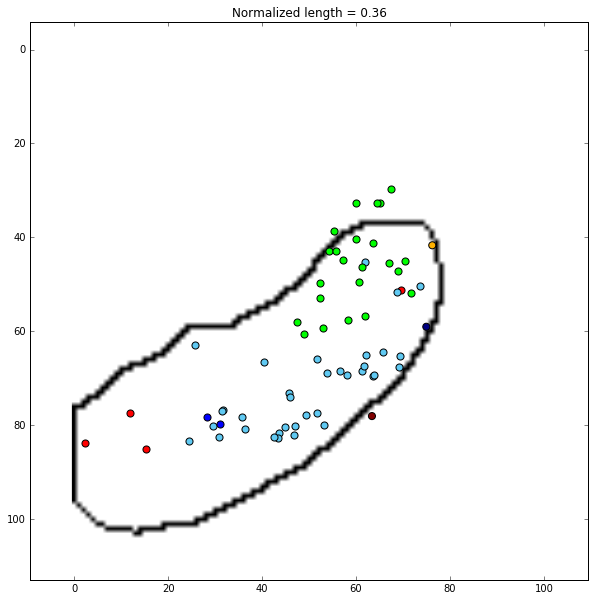

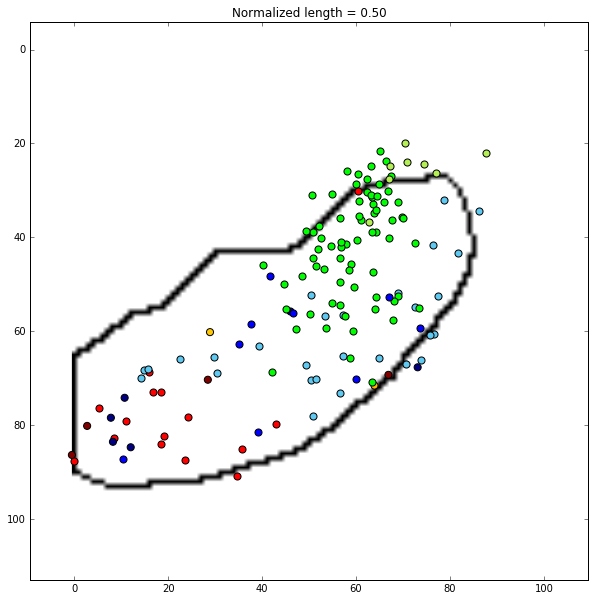

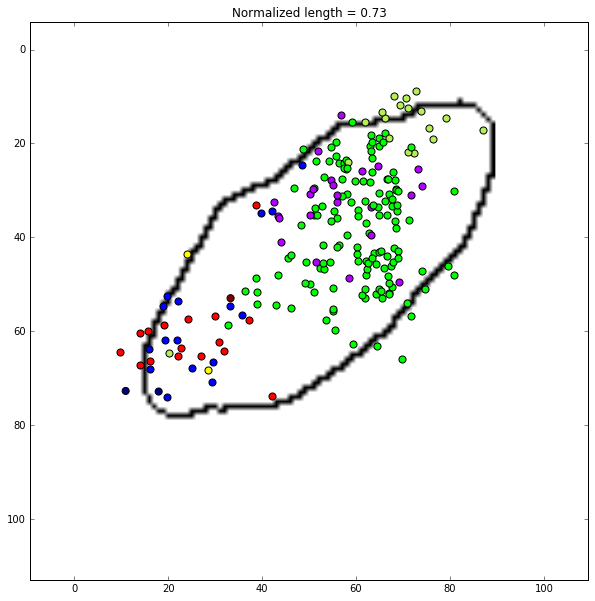

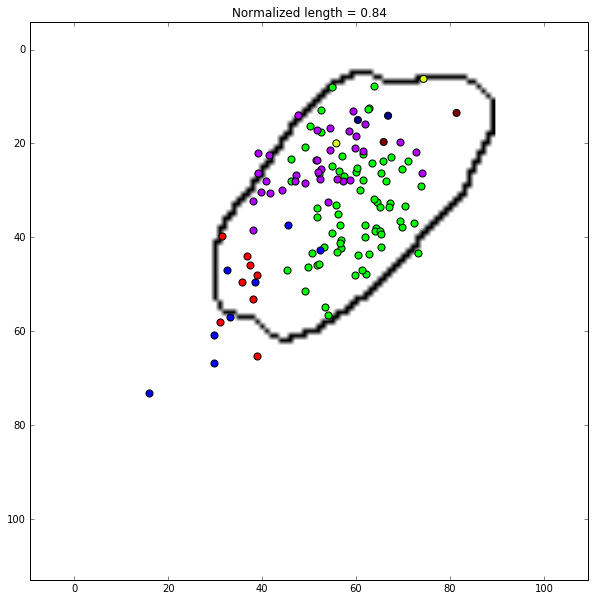

In [197]:
for r in [0.2, .36, 0.5, 0.73, 0.84]:
    
    plt.figure(figsize=(10,10));
    plt.axis('equal');
    plt.xlim([-50, 150]);
    
#     contour = find_contour_points(SNR_L_vol_down32_level01[:, int(xdim*r), :], sample_every=1)[1][0]
#     plt.scatter( contour[:,1], contour[:,0], c=(0,0,0));

    contour = np.maximum(0, find_contour_points(SNR_L_vol_down32_level01[:, int(xdim*r), :], sample_every=1)[1][0])
    viz = np.ones((ydim, zdim), np.uint8)
    viz[contour[:,1], zdim - 1 - contour[:,0]] = 0

#     plt.imshow(SNR_L_vol_down32_level01[:, int(xdim*r), ::-1], cmap=plt.cm.gray);

    plt.imshow(viz, cmap=plt.cm.gray);

    for brain_name, aligned_markers_rel2atlas_um in aligned_markers_rel2atlas_um_all_brains.iteritems():

        aligned_markers_rel2SNR_L_centroid_um = aligned_markers_rel2atlas_um.values() - SNR_L_nominal_location_um_wrt_canonicalAtlasSpace
        aligned_markers_rel2SNR_L_origin_um = aligned_markers_rel2SNR_L_centroid_um + SNR_L_vol_down32_level01_centroid_wrt_SNR_L_origin * convert_resolution_string_to_um('down32', 'MD589')
        aligned_markers_rel2SNR_L_origin_down32 = aligned_markers_rel2SNR_L_origin_um / convert_resolution_string_to_um('down32', 'MD589')

        on_plane = (aligned_markers_rel2SNR_L_origin_down32[:,0] < xdim*r + 5) & \
        (aligned_markers_rel2SNR_L_origin_down32[:,0] > xdim*r - 5)

        yzs = aligned_markers_rel2SNR_L_origin_down32[on_plane][:, [1,2]]

        plt.scatter(zdim - yzs[:,1],  yzs[:,0], c=experiments[brain_name]['marker_color'], s=50);
        
    plt.title('Normalized length = %.2f' % r);
    
    plt.savefig('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/ProjectionLabeling/lauren_data_v2/coronal_normalizedLevel_%.2f.png' % r)
    plt.show();
    
    

# Export all visualizations

In [3]:
for stack in ['LM86']:
# for stack in experiments.keys():
    
#     for view in ['coronal', 'horizontal_topDown', 'sagittal', '45']:
    for view in ['coronal']:

        snapshot_fp = '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/ProjectionLabeling/lauren_data_v3_50markers/%(view)s/%(stack)s_%(view)s.png' % {'stack':stack, 'view':view}
        create_parent_dir_if_not_exists(snapshot_fp)

        if view == 'sagittal':
            view_up = (0.000000, -1.000000, 0.000000)
            focal = (-2251.592570, -1170.828137, 1.000000)
            position = (-2251.592570, -1170.828137, -30000.000000)
        elif view == 'coronal':
            view_up = (0.3, -1, 0)
            focal = (-2250, -1170, 0.000000)
            position = (-11244, -4410, 0)
        elif view == 'horizontal':
            view_up = (1.1, 0.000000, 0.000000)
            focal = (-30000, 0, 0.000000)
            position = (-1, 0, 0)
        elif view == '45':
            view_up = (1.1, 0.000000, 0.000000)
            focal = (-30000, 0, 0.000000)
            position = (-1, 0, 0)
            
        launch_vtk(
            atlas_structure_actors_um.values()
            + \
            markers_rel2atlas_actors[stack] \
            + \
            [shell_actor_um_wrt_canonicalAtlasSpace] \
            ,
            background_color=(1,1,1), 
            axes_label_color=(0,0,0), 
            interactive=False,
            snapshot_fn=snapshot_fp,
            snapshot_magnification=2,
            view_up=view_up,
            focal=focal,
            position=position
        )
    

NameError: name 'atlas_structure_actors_um' is not defined